# [Stellar Classification Dataset - SDSS17](https://www.kaggle.com/datasets/fedesoriano/stellar-classification-dataset-sdss17?resource=download)
#### Classification of Stars, Galaxies and Quasars. Sloan Digital Sky Survey DR17

## Imports

In [3]:
import math
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from scipy.stats import multivariate_normal
from statistics import mode

import pandas as pd
from IPython.display import display
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.colheader_justify', 'center')
pd.set_option('display.precision', 3)

from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.linear_model import RidgeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.datasets import load_iris

## General Purpose Methods

### Distance

In [43]:
class Distance:
    @staticmethod
    def squared_euclidean_distance(X,y):
        # Tile the vector y to create a matrix with the same number 
        # of rows as X and the same number of columns as y
        y = np.tile(y, (X.shape[0], 1))
        
        # Calculate the squared Euclidean distance between each row of x and y
        squared_distance = np.square(X - y).sum(axis=1)
        
        return squared_distance

    @staticmethod
    def euclidean_distance(X, y):
        squared_distance = Distance.squared_euclidean_distance(X,y)
        
        # Take the square root to get the Euclidean distance
        distance = np.sqrt(squared_distance)
    
        return distance

### Curves

In [44]:
class Curve:
    @staticmethod
    def cross_validation_cost_evolution_curve(caption, costs):
        # Select best hyperparameter
        param = np.argmin(costs) + 1

        # Plot the evolution of the validation error with respect to the best hyperparameter
        plt.plot(range(1, len(costs)+1), costs * 100, marker='o', color='crimson')
        plt.title('K-fold cross validation error evolution')
        plt.ylabel('Average Validation Error %')
        plt.xlabel(caption)
        plt.show()
        return param
    
    @staticmethod
    def accuracy_evolution_curve(caption, accuracies):
        # Select best hyperparameter
        param = np.argmax(accuracies) + 1

        # Plot the evolution of the validation error with respect to the best hyperparameter
        plt.plot(range(1, len(accuracies)+1), accuracies, marker='o', color='#3B7A57')
        plt.title('Accuracy evolution')
        plt.ylabel('Accuracy')
        plt.xlabel(caption)
        plt.show()
        return param
    
    @staticmethod
    def cross_entropy_loss_curve(train_losses, test_losses):
        # Plot the evolution of the cross entropy loss
        plt.plot(range(1, len(train_losses)+1), train_losses, marker='.', color='crimson', label='Train set')
        plt.plot(range(1, len(test_losses)+1), test_losses, marker='.', color='darkslateblue', label='Test set')
        plt.suptitle('Cross entropy loss evolution', y=1.03)
        plt.title(r'$L(\hat y, y) = -\frac{1}{N} \sum_{i=1}^N {\sum_{k=1}^K{y_i \log(\hat y_i)}}$')
        plt.ylabel('Cross entropy loss')
        plt.xlabel('Epoch')
        plt.ylim(0,1)
        plt.legend()
        plt.show()
    
    @staticmethod
    def EM_alg_cost_evolution_curve(costs):
        total_iterations = len(costs)//2

        # Plot the evolution of the cost function
        for i in range(2*total_iterations-1):
            # Alternate the marker color for costs calculated after an expectation step (even position) 
            # or a maximization step (odd position)
            color = 'darkslateblue' if i % 2 == 0 else 'crimson'
            label = 'After Expectation Step' if i == 0 else 'After Maximization Step' if i == 1 else ''
            plt.plot([i, i+1], [costs[i], costs[i+1]], marker='o', mfc=color, mec=color, ms='7', ls=':', color='black', label=label)
        last_point = 2*total_iterations-1
        plt.plot(last_point, costs[last_point], marker='o', mfc='crimson', mec='crimson', ms='7')

        plt.xlabel('Iteration')
        plt.ylabel('Cost')
        plt.suptitle('K-means cost evolution', y=1.03)
        plt.title(r'Cost function: $\frac{1}{2}\sum_{i=1}^{N} ||\mathbf{x}_{i} - \mathbf{\hat\mu}_{\hat y_{i}}||^{2}$')
        plt.grid(True)
        plt.legend()

        iterations_ticks = [val for i in range(1, total_iterations + 1) for val in ['', i]]
        plt.xticks(range(2*total_iterations), iterations_ticks)
        
        plt.show()

        # Construct reporting table
        data = []

        for i in range(len(costs)):
            iter = str(i//2)+'a' if i%2==0 else str(i//2)+'b'  # Increasing index for every 2 rows
            step = 'E-step' if i % 2 == 0 else 'M-step'
            cost = costs[i]
            data.append({'Iteration': iter, 'Step': step, 'Cost': cost})

        cost_evolution = pd.concat([pd.DataFrame([d]) for d in data], ignore_index=True).set_index('Iteration')

        return cost_evolution
        

### Reporting Tables

In [45]:
class Report:
    @staticmethod
    def gaussian_naive_bayes_parameters(caption, priors, means, covariance_matrix, num_classes, num_features):
        
        print(caption,"- Priors")
        custom_priors_df = pd.DataFrame(priors.reshape(1, -1), columns=[f'Class_{i}' for i in range(num_classes)])
        display(custom_priors_df)

        print(caption," - Means")
        custom_means_df = pd.DataFrame(means, columns=[f'Feature_{i}' for i in range(num_features)], index=[f'Class_{i}' for i in range(num_classes)])
        display(custom_means_df)

        print(caption," - Covariance Matrix per class")
        for covariance in covariance_matrix:
            custom_covariance_df = pd.DataFrame(covariance, columns=[f'Feature_{i}' for i in range(num_features)], index=[f'Feature_{i}' for i in range(num_features)])
            display(custom_covariance_df)

## Fetch Data

### Load the User Modeling Dataset

In [176]:
user_training_data = pd.read_excel("../resources/user+knowledge+modeling/Data_User_Modeling_Dataset_Hamdi Tolga KAHRAMAN.xls", sheet_name="Training_Data")
user_training_data = user_training_data.drop(columns=["Unnamed: 6", "Unnamed: 7", "Attribute Information:"])
print(user_training_data.head(6))

user_test_data = pd.read_excel("../resources/user+knowledge+modeling/Data_User_Modeling_Dataset_Hamdi Tolga KAHRAMAN.xls", sheet_name="Test_Data")
user_test_data = user_test_data.drop(columns=["Unnamed: 6", "Unnamed: 7", "Attribute Information:"])
print(user_test_data.head(6))

    STG   SCG   STR   LPR   PEG     UNS  
0  0.00  0.00  0.00  0.00  0.00  very_low
1  0.08  0.08  0.10  0.24  0.90      High
2  0.06  0.06  0.05  0.25  0.33       Low
3  0.10  0.10  0.15  0.65  0.30    Middle
4  0.08  0.08  0.08  0.98  0.24       Low
5  0.09  0.15  0.40  0.10  0.66    Middle
    STG   SCG   STR   LPR   PEG     UNS  
0  0.00  0.10  0.50  0.26  0.05  Very Low
1  0.05  0.05  0.55  0.60  0.14       Low
2  0.08  0.18  0.63  0.60  0.85      High
3  0.20  0.20  0.68  0.67  0.85      High
4  0.22  0.22  0.90  0.30  0.90      High
5  0.14  0.14  0.70  0.50  0.30       Low


### Load Iris dataset

In [177]:
iris_data = load_iris(as_frame=True)
iris_data.frame.head(5)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


### Load the Star Classification Dataset

In [56]:
star_data = pd.read_csv("../resources/star_classification.csv")

# Set the random seed for reproducibility
seed_value = 42
star_data = star_data.sample(n=1000, random_state=seed_value)
star_data.head(5)

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
75721,1.238e+18,16.957,3.646,23.335,21.951,20.481,19.603,19.131,7712,301,6,442,4.855e+18,GALAXY,5.062e-01,4312,55511,495
80184,1.238e+18,240.063,6.134,17.860,16.792,16.430,16.309,16.259,3894,301,1,243,2.449e+18,STAR,3.448e-04,2175,54612,348
19864,1.238e+18,30.887,1.189,18.189,16.895,16.422,16.246,16.185,7717,301,1,536,8.255e+18,STAR,4.085e-06,7332,56683,943
76699,1.238e+18,247.594,10.888,25.000,21.712,21.471,21.305,21.291,5323,301,1,134,4.578e+18,STAR,-2.915e-04,4066,55444,326
92991,1.238e+18,18.896,-5.261,23.766,21.797,20.695,20.234,19.975,7881,301,3,148,8.910e+18,STAR,-1.362e-04,7914,57331,363


### Data Preparation of Iris Dataset

In [178]:
# split initial data into train and test (50 examples for test)
X_train, X_test, y_train, y_test = train_test_split(iris_data.data.to_numpy(), 
                                                    iris_data.target.to_numpy(), 
                                                    test_size=50, random_state=42)


# split rest of the train data into train and dev (50 examples for dev)
X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, 
                                                  test_size=50, random_state=42)

### Data Preparation of User Modeling Dataset

In [209]:
validation_size = 30
y_keys = {"VERYLOW": 0, "LOW": 1, "MIDDLE": 2, "HIGH": 3}

y_convert = lambda x: y_keys[x]

# Randomly select 50 rows for validation
validation_data = user_training_data.sample(n=validation_size, random_state=54)

# Use the rest of the data for training
training_data = user_training_data.drop(validation_data.index)

training_data[' UNS'] = training_data[' UNS'].str.upper().str.strip().str.replace('_','').str.replace(' ', '')
validation_data[' UNS'] = validation_data[' UNS'].str.upper().str.strip().str.replace('_','').str.replace(' ', '')
user_test_data[' UNS'] = user_test_data[' UNS'].str.upper().str.strip().str.replace('_','').str.replace(' ', '')

# Extract X_train and y_train from the training data
X_train = np.array(training_data[['STG', 'SCG', 'STR', 'LPR', 'PEG']])
y_train = np.array(list(map(y_convert, training_data[' UNS']))).astype(int)

# Extract X_validation and y_validation from the validation data
X_dev = np.array(validation_data[['STG', 'SCG', 'STR', 'LPR', 'PEG']])
y_dev = np.array(list(map(y_convert, validation_data[' UNS']))).astype(int)

# Extract X_test and y_test from the test data
X_test = np.array(user_test_data[['STG', 'SCG', 'STR', 'LPR', 'PEG']])
y_test = np.array(list(map(y_convert, user_test_data[' UNS']))).astype(int)


### Context

In astronomy, stellar classification is the classification of stars based on their spectral characteristics. The classification scheme of galaxies, quasars, and stars is one of the most fundamental in astronomy. The early cataloguing of stars and their distribution in the sky has led to the understanding that they make up our own galaxy and, following the distinction that Andromeda was a separate galaxy to our own, numerous galaxies began to be surveyed as more powerful telescopes were built. This datasat aims to classificate stars, galaxies, and quasars based on their spectral characteristics.

### Content


The data consists of 100,000 observations of space taken by the SDSS (Sloan Digital Sky Survey). Every observation is described by 17 feature columns and 1 class column which identifies it to be either a star, galaxy or quasar.

Here is a description of the features and the `class`:

<table>
<thead>
<tr><th>Variable Name </th><th>Variable Description </th></tr>
</thead>
<tr><td>obj_ID</td><td>Object Identifier, the unique value that identifies the object in the image catalog used by the CAS</td></tr>
<tr><td>alpha</td><td>Right Ascension angle (at J2000 epoch)</td></tr>
<tr><td>delta</td><td>Declination angle (at J2000 epoch)</td></tr>
<tr><td>u</td><td>Ultraviolet filter in the photometric system</td></tr>
<tr><td>g</td><td>Green filter in the photometric system</td></tr>
<tr><td>r</td><td>Red filter in the photometric system</td></tr>
<tr><td>i</td><td>Near Infrared filter in the photometric system</td></tr>
<tr><td>z</td><td>Infrared filter in the photometric system</td></tr>
<tr><td>run_ID</td><td>Run Number used to identify the specific scan</td></tr>
<tr><td>rereun_ID</td><td>Rerun Number to specify how the image was processed</td></tr>
<tr><td>cam_col</td><td>Camera column to identify the scanline within the run</td></tr>
<tr><td>field_ID</td><td>Field number to identify each field</td></tr>
<tr><td>spec_obj_ID</td><td>Unique ID used for optical spectroscopic objects (this means that 2 different observations with the same spec_obj_ID must share the output class)</td></tr>
<tr><td><h8 style="color:Crimson;">class<h8></td><td>object class (galaxy, star or quasar object)</td></tr>
<tr><td>redshift</td><td>redshift value based on the increase in wavelength</td></tr>
<tr><td>plate</td><td>plate ID, identifies each plate in SDSS</td></tr>
<tr><td>MJD</td><td>Modified Julian Date, used to indicate when a given piece of SDSS data was taken</td></tr>
<tr><td>fiber_ID</td><td>fiber ID that identifies the fiber that pointed the light at the focal plane in each observation</td></tr>
<tbody>
</tbody>
</table>


### Main Task

Our task is to classify each observations. There are in total 3 classes:
* `Galaxy`
* `Star`
* `Quasar Object`

Every record belongs to a single class (Multiclassification Problem)

### Data Preparation for Star Classification  Dataset

In our main dataset, our goal is to descriminate between the space observations and classify for each of them its category. For this reason, there are some features that may not be directly useful for classification, or they may be redundant. Here are the variables that thei are not going to be used:

* `obj_ID` (Object Identifier): While it uniquely identifies an object, it may not provide information about the intrinsic properties of the object relevant to classification.

* `alpha` (Right Ascension angle) and `delta` (Declination angle): These are celestial coordinates that indicate the position of an object in the sky. They are more related to the spatial location than the object's class.

* `run_ID`, `rerun_ID`, `cam_col`, `field_ID`: These are identifiers and numbers related to the observational setup. While they are important for organizing and retrieving data, they don't directly convey information about the nature of the observed objects.

* `plate`: This may be more relevant for tracking the observational setup and might not directly contribute to the object's class.

* `MJD` (Modified Julian Date): It represents the time of observation and might not be directly related to the intrinsic properties used for classification.

* `fiber_ID`: While important for identifying the specific fiber used in spectroscopy, it might not directly contribute to the classification of the object into predefined classes.

> These variables might still be useful for other types of analyses, but for a classification task, the focus is generally on features that directly reflect the intrinsic properties of the objects being classified (e.g., photometric measurements, redshift, etc.).

In [57]:
columns_to_drop = ["obj_ID", "run_ID", "rerun_ID", "cam_col", "field_ID", "plate", "MJD", "fiber_ID", "alpha", "delta"]
star_data = star_data.drop(columns=columns_to_drop)

# split initial data into train and test (20% examples for test)
X_train, X_test, y_train, y_test = train_test_split(star_data[['u', 'g', 'r', 'i', 'z', 'redshift']], 
                                                    star_data['class'], 
                                                    test_size=0.2, random_state=42)

# split rest of the train data into train and dev (10% examples for dev)
X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, 
                                                  test_size=0.1, random_state=42)

X_train = np.array(X_train)
X_dev = np.array(X_dev)
X_test = np.array(X_test)

y_train = np.array(y_train)
y_dev = np.array(y_dev)
y_test = np.array(y_test)

## KNN Classification

### Custom kNN Classifier

Below, we implement the well-known kNN algorithm. Note that the Euclidean distance is used as the distance metric for measuring the distance between test set examples and train set examples. Next, two functions are included for finding the best value for the hyperparameter ($k$):

1. Cross Validation Method (`k_fold_cross_validation`):
This method performs cross-validation to find the best value for the hyperparameter $k$. It sets the error each time as the average validation error (across all folds in which the train set is divided each time). Finally, it returns the value of $k$ that resulted in the smallest error.

2. Accuracy-based Validation Method (`accuracy_based_validation`):
This method returns the first value of $k$ that provides the best accuracy on the validation data.

In [58]:
class kNN:
    def __init__(self, k):
        # k nearest neighbours hyperparameter
        self.k = k

        # X_train: n*m matrix (n examples, m features)
        # X[i] = [xi1, xi2, ..., xim] for i=1 to n
        self.X_train = None
        
        # y_train: n*1 vector (class of each example)
        # y[i] = class of X[i]  for i=1 to n
        self.y_train = None
    
    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train

    def predict(self, X_test):
        Ntest = X_test.shape[0]
        predicted_classes = list()

        for test_example_idx in range(Ntest):
            # Calculate the distance for all train examples
            d = Distance.euclidean_distance(self.X_train, X_test[test_example_idx,:])

            # Return the indices of the K closest instances
            k_closest = np.argsort(d)[:self.k]

            # Find the classes of the k closest instances
            y = self.y_train[k_closest]

            # mode: returns the most frequent (majority vote)
            predicted_classes.append(mode(y))

        return np.array(predicted_classes)

In [59]:
def k_fold_cross_validation(K, numFolds, X, y):
    """
    Perform k-fold cross-validation for kNN.

    Parameters:
    - K: Number of nearest neighbors to test.
    - numFolds: Number of folds for cross-validation.
    - X: Training data features.
    - y: Labels for the training data.

    Returns:
    - best_k: Best k value based on cross-validation.
    """

    N = X.shape[0]
    np.random.seed(10)
    perm = np.random.permutation(N)
    X = X[perm]
    y = y[perm]

    chunk_size = int(N / numFolds)
    split_indices = np.arange(chunk_size, chunk_size * numFolds, chunk_size)

    if chunk_size * numFolds < N:
        split_indices[-1] = N - 1
    else:
        last_chunk = chunk_size

    Xfolds = np.vsplit(X, split_indices)
    yfolds = np.hsplit(y, split_indices)

    errors = np.zeros((K, numFolds))

    for k in tqdm(range(1, K + 1)):
        for j in range(numFolds):
            X_train = np.vstack([Xfolds[i] for i in range(len(Xfolds)) if i != j])
            y_train = np.hstack([yfolds[i] for i in range(len(yfolds)) if i != j])
            X_test = Xfolds[j]

            knn = kNN(k)
            knn.fit(X_train, y_train)
            y_test = knn.predict(X_test)

            # Compute the percent misclassified data points
            errors[k - 1, j] = np.count_nonzero(y_test != yfolds[j]) / X_test.shape[0]
            print("kNN for k = {}, fold # {}, error = {} ".format(k, j, errors[k - 1, j]))

    val = errors.sum(axis=1) / numFolds

    best_k = Curve.cross_validation_cost_evolution_curve("k Nearest Neighbours", val)
    
    print('Smallest average error:', val[best_k - 1])
    print('Best k:', best_k)

    return best_k

In [60]:
def accuracy_based_validation(K, X_train, y_train, X_dev, y_dev):
  """
  Perform accuracy-based validation for the kNN algorithm.

  Parameters:
  - K: Number of nearest neighbors to test.
  - X_train: Training data features.
  - y_train: Labels for the training data.
  - X_dev: Development data features for validation.
  - y_dev: Labels for the development data.

  Returns:
  - best_k: The value of k that achieved the highest accuracy on the development data.
  """
    
  accuracies = np.zeros(K)

  for k in tqdm(range(1, K + 1)):
    knn = kNN(k)  # knn object with current k
    knn.fit(X_train, y_train) # fit with current k in the training data

    predictions = knn.predict(X_dev) # predict with current k using the development data
    accuracy = accuracy_score(y_dev, predictions) # count accuracy
    accuracies[k - 1] = accuracy
    
    print('Accuracy for k={0}: {1}'.format(k, accuracy))
    
  best_k = Curve.accuracy_evolution_curve("k Nearest Neighbours", accuracies)
    
  print('Best dev accuracy:', accuracies[best_k - 1])
  print('Best k:', best_k)

  return best_k

### Training & Testing

#### Optimal value of the hyperparameter $k$

Below we find the optimal value of the hyperparameter $k$ in the range [1, 10] -using both functions defined previously (`k_fold_cross_validation` and `accuracy_based_validation`)- and present our results for each value of $k$.

- `k_fold_cross_validation`

 10%|█         | 1/10 [00:00<00:01,  8.15it/s]

kNN for k = 1, fold # 0, error = 0.1388888888888889 
kNN for k = 1, fold # 1, error = 0.19444444444444445 
kNN for k = 1, fold # 2, error = 0.125 
kNN for k = 1, fold # 3, error = 0.08333333333333333 
kNN for k = 1, fold # 4, error = 0.19444444444444445 
kNN for k = 1, fold # 5, error = 0.09722222222222222 
kNN for k = 1, fold # 6, error = 0.1111111111111111 
kNN for k = 1, fold # 7, error = 0.1388888888888889 
kNN for k = 1, fold # 8, error = 0.125 
kNN for k = 1, fold # 9, error = 0.16666666666666666 
kNN for k = 2, fold # 0, error = 0.1388888888888889 
kNN for k = 2, fold # 1, error = 0.19444444444444445 
kNN for k = 2, fold # 2, error = 0.125 
kNN for k = 2, fold # 3, error = 0.08333333333333333 
kNN for k = 2, fold # 4, error = 0.19444444444444445 
kNN for k = 2, fold # 5, error = 0.09722222222222222 
kNN for k = 2, fold # 6, error = 0.1111111111111111 
kNN for k = 2, fold # 7, error = 0.1388888888888889 
kNN for k = 2, fold # 8, error = 0.125 
kNN for k = 2, fold # 9, error = 0.1

 30%|███       | 3/10 [00:00<00:00,  9.11it/s]

kNN for k = 3, fold # 0, error = 0.1388888888888889 
kNN for k = 3, fold # 1, error = 0.20833333333333334 
kNN for k = 3, fold # 2, error = 0.1527777777777778 
kNN for k = 3, fold # 3, error = 0.1111111111111111 
kNN for k = 3, fold # 4, error = 0.1527777777777778 
kNN for k = 3, fold # 5, error = 0.1111111111111111 
kNN for k = 3, fold # 6, error = 0.16666666666666666 
kNN for k = 3, fold # 7, error = 0.16666666666666666 
kNN for k = 3, fold # 8, error = 0.1388888888888889 
kNN for k = 3, fold # 9, error = 0.16666666666666666 
kNN for k = 4, fold # 0, error = 0.1388888888888889 
kNN for k = 4, fold # 1, error = 0.18055555555555555 
kNN for k = 4, fold # 2, error = 0.1527777777777778 
kNN for k = 4, fold # 3, error = 0.08333333333333333 
kNN for k = 4, fold # 4, error = 0.1527777777777778 
kNN for k = 4, fold # 5, error = 0.1388888888888889 
kNN for k = 4, fold # 6, error = 0.1111111111111111 
kNN for k = 4, fold # 7, error = 0.1388888888888889 
kNN for k = 4, fold # 8, error = 0.125 


 50%|█████     | 5/10 [00:00<00:00,  8.70it/s]

kNN for k = 5, fold # 2, error = 0.1527777777777778 
kNN for k = 5, fold # 3, error = 0.09722222222222222 
kNN for k = 5, fold # 4, error = 0.16666666666666666 
kNN for k = 5, fold # 5, error = 0.1111111111111111 
kNN for k = 5, fold # 6, error = 0.18055555555555555 
kNN for k = 5, fold # 7, error = 0.16666666666666666 
kNN for k = 5, fold # 8, error = 0.1388888888888889 
kNN for k = 5, fold # 9, error = 0.18055555555555555 
kNN for k = 6, fold # 0, error = 0.16666666666666666 
kNN for k = 6, fold # 1, error = 0.19444444444444445 
kNN for k = 6, fold # 2, error = 0.1527777777777778 
kNN for k = 6, fold # 3, error = 0.08333333333333333 
kNN for k = 6, fold # 4, error = 0.1527777777777778 
kNN for k = 6, fold # 5, error = 0.1111111111111111 
kNN for k = 6, fold # 6, error = 0.18055555555555555 
kNN for k = 6, fold # 7, error = 0.16666666666666666 
kNN for k = 6, fold # 8, error = 0.16666666666666666 


 70%|███████   | 7/10 [00:00<00:00,  9.37it/s]

kNN for k = 6, fold # 9, error = 0.18055555555555555 
kNN for k = 7, fold # 0, error = 0.16666666666666666 
kNN for k = 7, fold # 1, error = 0.20833333333333334 
kNN for k = 7, fold # 2, error = 0.1527777777777778 
kNN for k = 7, fold # 3, error = 0.09722222222222222 
kNN for k = 7, fold # 4, error = 0.16666666666666666 
kNN for k = 7, fold # 5, error = 0.1527777777777778 
kNN for k = 7, fold # 6, error = 0.18055555555555555 
kNN for k = 7, fold # 7, error = 0.19444444444444445 
kNN for k = 7, fold # 8, error = 0.16666666666666666 
kNN for k = 7, fold # 9, error = 0.19444444444444445 
kNN for k = 8, fold # 0, error = 0.16666666666666666 
kNN for k = 8, fold # 1, error = 0.20833333333333334 
kNN for k = 8, fold # 2, error = 0.1527777777777778 
kNN for k = 8, fold # 3, error = 0.08333333333333333 
kNN for k = 8, fold # 4, error = 0.125 
kNN for k = 8, fold # 5, error = 0.125 
kNN for k = 8, fold # 6, error = 0.1527777777777778 
kNN for k = 8, fold # 7, error = 0.20833333333333334 
kNN fo

 90%|█████████ | 9/10 [00:00<00:00,  9.38it/s]

kNN for k = 9, fold # 0, error = 0.19444444444444445 
kNN for k = 9, fold # 1, error = 0.19444444444444445 
kNN for k = 9, fold # 2, error = 0.1527777777777778 
kNN for k = 9, fold # 3, error = 0.09722222222222222 
kNN for k = 9, fold # 4, error = 0.1527777777777778 
kNN for k = 9, fold # 5, error = 0.16666666666666666 
kNN for k = 9, fold # 6, error = 0.1527777777777778 
kNN for k = 9, fold # 7, error = 0.20833333333333334 
kNN for k = 9, fold # 8, error = 0.1388888888888889 
kNN for k = 9, fold # 9, error = 0.19444444444444445 
kNN for k = 10, fold # 0, error = 0.19444444444444445 
kNN for k = 10, fold # 1, error = 0.19444444444444445 
kNN for k = 10, fold # 2, error = 0.1527777777777778 
kNN for k = 10, fold # 3, error = 0.08333333333333333 
kNN for k = 10, fold # 4, error = 0.1388888888888889 
kNN for k = 10, fold # 5, error = 0.1527777777777778 
kNN for k = 10, fold # 6, error = 0.16666666666666666 
kNN for k = 10, fold # 7, error = 0.2222222222222222 
kNN for k = 10, fold # 8, er

100%|██████████| 10/10 [00:01<00:00,  9.34it/s]


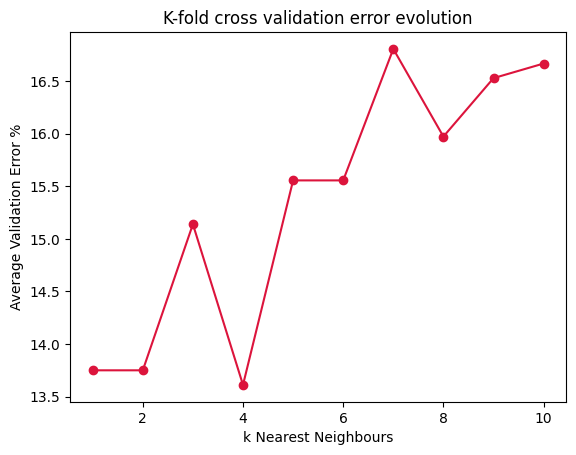

Smallest average error: 0.13611111111111113
Best k: 4


In [61]:
K = 10 # Find the best k hyperparameter in range (1, K)
numFolds = 10 # Number of folds for cross validation

cross_val_best_k = k_fold_cross_validation(K, numFolds, X_train, y_train)

- `accuracy_based_validation`

100%|██████████| 10/10 [00:00<00:00, 52.21it/s]

Accuracy for k=1: 0.875
Accuracy for k=2: 0.875
Accuracy for k=3: 0.8625
Accuracy for k=4: 0.8875
Accuracy for k=5: 0.85
Accuracy for k=6: 0.85
Accuracy for k=7: 0.8125
Accuracy for k=8: 0.825
Accuracy for k=9: 0.8375
Accuracy for k=10: 0.8375


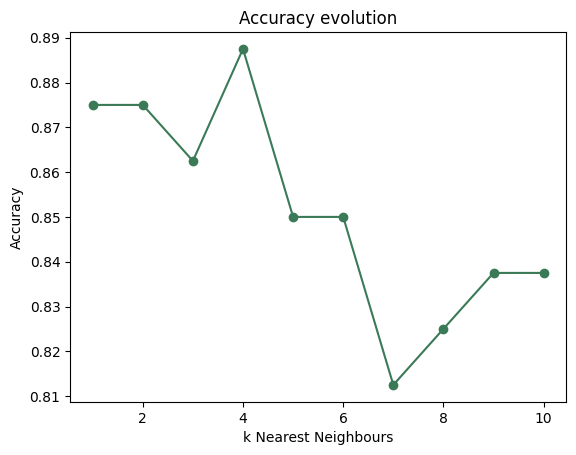

Best dev accuracy: 0.8875
Best k: 4


In [62]:
K = 10
acc_based_best_k = accuracy_based_validation(K, X_train, y_train, X_dev, y_dev)

#### Custom kNN Classifier

- Using the `k_fold_cross_validation` result as $k$


First, the values of the accuracy, precision, recall and f1-score metrics are presented for the train set. We anticipate the scores to equal 1.0 for the train set if k equals to 1: 

In [63]:
best_k = cross_val_best_k

# Training kNN Classifier
knn_custom = kNN(best_k) 
knn_custom.fit(X_train, y_train)

# Using kNN Classifier (train set)
y_custom = knn_custom.predict(X_train)
print(classification_report(y_train, y_custom))

              precision    recall  f1-score   support

      GALAXY       0.93      0.97      0.95       428
         QSO       0.97      0.90      0.93       141
        STAR       0.90      0.87      0.89       151

    accuracy                           0.93       720
   macro avg       0.94      0.91      0.92       720
weighted avg       0.93      0.93      0.93       720



Now, the values of the same metrics are presented for the test set. We anticipate lower values for the respective metrics than those calculated for the train set:

In [64]:
# Using kNN Classifier (test set)
y_custom = knn_custom.predict(X_test)
print(classification_report(y_test, y_custom))

              precision    recall  f1-score   support

      GALAXY       0.82      0.90      0.86       120
         QSO       0.97      0.88      0.92        33
        STAR       0.72      0.60      0.65        47

    accuracy                           0.82       200
   macro avg       0.84      0.79      0.81       200
weighted avg       0.82      0.82      0.82       200



- Using the `accuracy_based_validation` result as $k$

We repeat the process for both the train set and the test set:

In [65]:
best_k = acc_based_best_k

# Training kNN Classifier
knn_custom = kNN(best_k) 
knn_custom.fit(X_train, y_train)

# Using kNN Classifier (train set)
y_custom = knn_custom.predict(X_train)
print(classification_report(y_train, y_custom))

# Using kNN Classifier (test set)
y_custom = knn_custom.predict(X_test)
print(classification_report(y_test, y_custom))

              precision    recall  f1-score   support

      GALAXY       0.93      0.97      0.95       428
         QSO       0.97      0.90      0.93       141
        STAR       0.90      0.87      0.89       151

    accuracy                           0.93       720
   macro avg       0.94      0.91      0.92       720
weighted avg       0.93      0.93      0.93       720

              precision    recall  f1-score   support

      GALAXY       0.82      0.90      0.86       120
         QSO       0.97      0.88      0.92        33
        STAR       0.72      0.60      0.65        47

    accuracy                           0.82       200
   macro avg       0.84      0.79      0.81       200
weighted avg       0.82      0.82      0.82       200



We can observe that the result of `k_fold_cross_validation` performs better on the test set (while on the train set both results yield maximum scores, as expected).

#### Scikit-Learn kNN Classifier

As implied by the last observation, the result of `k_fold_cross_validation` performs better and hence we will use it to train the Scikit-Learn's algorithm.

First, the values of the accuracy, precision, recall and f1-score metrics are presented for the train set:

In [66]:
best_k = cross_val_best_k

# Training kNN Classifier
knn_scikit = KNeighborsClassifier(n_neighbors=best_k) 
knn_scikit.fit(X_train, y_train)

# Using kNN Classifier (train set)
y_scikit = knn_scikit.predict(X_train)
print(classification_report(y_train, y_scikit))

              precision    recall  f1-score   support

      GALAXY       0.86      0.97      0.91       428
         QSO       0.96      0.88      0.92       141
        STAR       0.87      0.64      0.74       151

    accuracy                           0.88       720
   macro avg       0.90      0.83      0.86       720
weighted avg       0.88      0.88      0.88       720



Now, the values of the same metrics are presented for the test set. We anticipate lower values for the respective metrics than those calculated for the train set:

In [67]:
# Using kNN Classifier (test set)
y_scikit = knn_scikit.predict(X_test)
print(classification_report(y_test, y_scikit))

              precision    recall  f1-score   support

      GALAXY       0.81      0.93      0.87       120
         QSO       0.91      0.88      0.89        33
        STAR       0.77      0.49      0.60        47

    accuracy                           0.82       200
   macro avg       0.83      0.77      0.79       200
weighted avg       0.82      0.82      0.81       200



####  Observations

TEXT HERE

## K-means Clustering

Below, we implement the well-known k-means clustering algorithm, an E-M algorithm. Note that the squared Euclidean distance is used as the distance metric during the expectation step.
Regarding the cantroid initialization, there are two well known methods:

1. <b>Random data points</b>: In this approach, $k$ random data points are selected from the dataset and used as the initial centroids.

2. <b>K-means++</b>: As spreading out the initial centroids is thought to be a worthy goal, k-means++ pursues this by assigning the first centroid to the location of a randomly selected data point, and then choosing the subsequent centroids from the remaining data points based on a probability proportional to the squared distance away from a given point's nearest existing centroid.

[Centroid initialization](https://www.kdnuggets.com/2020/06/centroid-initialization-k-means-clustering.html)

In our implementation we initialize the centroids using the first method.

### Custom k-means

In [68]:
class kMeans:
    def __init__(self, k, max_iters):
        # k = number of clusters
        self.k = k
        # define the maximum number of iterations
        self.max_iters = max_iters
        # the centroids for all labels
        self.centroids = None

    @staticmethod
    def cost_function(X, c, labels): 
        return 0.5*sum(Distance.squared_euclidean_distance(X[i].reshape((1,X[i].shape[0])), c[labels[i]]) for i in range(X.shape[0]))
    
    def fit(self, X):
        # Choose k random points of data as centroids
        indices = np.random.choice(X.shape[0], self.k, replace=False)
        self.centroids = X[indices]

        costs = list()

        for _ in range(self.max_iters):
            # Expectation step
            labels = self.predict(X)  # Assign each data point to the nearest centroid
            costs.append(self.cost_function(X, self.centroids, labels).item()) # Calculate the cost 

            # Maximization step
            new_centroids = np.array([np.mean(X[labels == label], axis=0) for label in range(self.k)])
            costs.append(self.cost_function(X, new_centroids, labels).item()) # Calculate the new cost
            
            # If the algorithm has converged, then stop
            if np.all(self.centroids == new_centroids):
                break
                
            self.centroids = new_centroids

        iters = len(costs)//2
        return costs, iters

    def predict(self, X):
        # Assign each data point to the nearest centroid 
        distances = np.array([Distance.squared_euclidean_distance(self.centroids, x) for x in X])
        labels = np.argmin(distances, axis=1)

        return labels


### Training & Testing

💡We will use the KMeans algorithm to cluster the observations of the training set (X_train), as clustering is commonly performed for grouping existing observations rather than predicting the cluster to which a new observation would belong. 

❗For evaluating the algorithm's performance, it is crucial to note that the cluster labels assigned by KMeans may not necessarily align with the true class labels. Therefore, other evaluation metrics should be employed, that take into account whether observations that normally belong to the same class are indeed found in the same cluster.

✔️We are going to use 3 commonly used clustering performance evaluation metrics (given that the ground truth is known):
1. <b>Adjusted Rand Index</b>: It is a function that measures the similarity of the two assignments, ignoring permutations:
    - $ARI = (RI - Expected_{RI}) / (max(RI) - Expected_{RI})$ <br> where $RI$ = (number of agreeing pairs) / (number of pairs)
    - The score range is [-1, 1]. Lower values indicate different labelings, similar clusterings have a high index and 1 is the perfect match score.

<br>
    
2. <b>Adjusted Mutual Information</b>: It is a function that measures the agreement of the two assignments, ignoring permutations. Two different normalized versions of this measure are available, Normalized Mutual Information (NMI) and Adjusted Mutual Information (AMI). NMI is often used in the literature, while AMI was proposed more recently and is normalized against chance. We will use AMI.
    - Values close to 0 indicate two label assignments that are largely independent, while values close to 1 indicate significant agreement. Further, an AMI of exactly 1 indicates that the two label assignments are equal (with or without permutation).

<br>

3. <b>Fowlkes-Mallows Index</b>: It is defined as the geometric mean of the pairwise precision and recall:
    - $FMI = \frac{TP}{\sqrt{(TP+FP)(TP+FN)}}$
    - The score ranges from 0 to 1. A high value indicates a good similarity between two clusters.

[Clustering performance evaluation](https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation)

Lastly, note that the hyperparameter $k$ is set to be equal to the number of classes

#### Custom k-means

In [69]:
num_of_classes = len(np.unique(y_train))
max_iters = 100

# Training k-means
k_means_custom = kMeans(num_of_classes, max_iters) 
costs, iters = k_means_custom.fit(X_train)

# Using k-means 
y_custom = k_means_custom.predict(X_train)

# Evaluation of clustering performance using appropriate metrics
ari = metrics.adjusted_rand_score(y_train, y_custom)
ami = metrics.adjusted_mutual_info_score(y_train, y_custom)
fm = metrics.fowlkes_mallows_score(y_train, y_custom)

print("Adjusted Rand Index (ARI): ", ari)
print("Adjusted Mutual Information (AMI): ", ami)
print("Fowlkes-Mallows Index (FM): ", fm)

Adjusted Rand Index (ARI):  0.049812606364897
Adjusted Mutual Information (AMI):  0.05195285364810989
Fowlkes-Mallows Index (FM):  0.42660730809388947


In [70]:
# Results
print("Iterations run: ", iters)
print("Final Cost: ", costs[-1])
print("Centroids: \n", k_means_custom.centroids)

Iterations run:  15
Final Cost:  1877.1426530539973
Centroids: 
 [[21.7793331  20.42160805 19.50855785 19.0737171  18.81250955  0.69397552]
 [19.25435867 17.74348215 17.03036276 16.70435635 16.48317895  0.11736273]
 [23.63710027 22.33853832 21.16957062 20.3836751  20.00563507  0.77068771]]


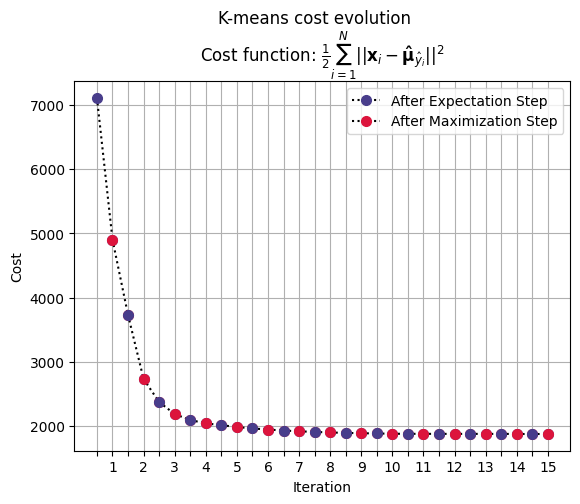

,Step,Cost
Iteration,,
0a,E-step,7107.098
0b,M-step,4901.726
1a,E-step,3727.705
1b,M-step,2731.407
2a,E-step,2373.156
2b,M-step,2186.442
3a,E-step,2093.306
3b,M-step,2041.969
4a,E-step,2013.476


In [71]:
# The evolution of the cost function
report_cost_evolution = Curve.EM_alg_cost_evolution_curve(costs)
display(report_cost_evolution)

#### Scikit-learn k-means

We set the centroid initialization method to be "random" in Scikit-Learn's implementation as well, for comparison purposes.

In [72]:
# Training k-means
k_means_scikit = KMeans(n_clusters=num_of_classes, init="random")
k_means_scikit.fit(X_train)

# Using k-means
y_scikit = k_means_scikit.predict(X_train)

# Evaluate clustering performance using appropriate metrics
ari = metrics.adjusted_rand_score(y_train, y_scikit)
ami = metrics.adjusted_mutual_info_score(y_train, y_scikit)
fm = metrics.fowlkes_mallows_score(y_train, y_scikit)

print("Adjusted Rand Index (ARI): ", ari)
print("Adjusted Mutual Information (AMI): ", ami)
print("Fowlkes-Mallows Index (FM): ", fm)

c:\Users\trian\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Adjusted Rand Index (ARI):  0.050993405601564346
Adjusted Mutual Information (AMI):  0.05249961576363895
Fowlkes-Mallows Index (FM):  0.4276032292873382


In [73]:
# Results
print("Iterations run: ", k_means_scikit.n_iter_)
print("Final Cost: ", 1/2 * k_means_scikit.inertia_)    # inertia does not include an 1/2 factor as we did in our implementation, so we need to multiply it to be able to compare the 2 costs
print("Centroids: \n", k_means_scikit.cluster_centers_)

Iterations run:  12
Final Cost:  1877.1366017847768
Centroids: 
 [[23.63294844 22.33703694 21.16798874 20.38137382 20.00319668  0.77007215]
 [21.77709116 20.4145404  19.50291377 19.07106623 18.81068005  0.69464175]
 [19.25435867 17.74348215 17.03036276 16.70435635 16.48317895  0.11736273]]


### Observations

TEXT

## Principal Component Analysis

### With SVD & Classic PCA

In [74]:
class PCA:
    def __init__(self, m):
        self.m = m

    def svd_reduction(self, X):
        U, S, V = np.linalg.svd(X, full_matrices=False)
        print( "U", U.shape, "S", S.shape, "V", V.shape )
        mu = X.mean(axis=0)

        eigvecs = V[:self.m,:]
        eigvals = S[:self.m]
        print( 'X', X.shape, 'eigvecs', eigvecs.shape, 'eigvals', eigvals.shape )
        Z = (X-mu).dot(eigvecs.T)
        print( 'Z', Z.shape )
        return Z, eigvecs, eigvals, mu
    
    def classic_reduction(self, X):
        mu = X.mean(axis=0).reshape( (1,-1) )

        normalized_X = X-mu

        S = (1/X.shape[0]) * normalized_X.T.dot( normalized_X )

        eigvectors, eigvals = self.eigsort( S )

        U = eigvectors[:,:self.m]
        Lambdas = eigvals[:self.m]
        print( X.shape, U.shape, Lambdas.shape )

        Z = normalized_X.dot(U)
        return Z, U, Lambdas, mu
    
    def eigsort(self, A):
        eigvals, U = np.linalg.eig(A)
        # sort eigenvalues in descending order
        order = np.argsort(eigvals)[::-1]
        eigvals = eigvals[order]
        #re-arrange the eigenvectors
        U = U[:,order]
        return U, eigvals

In [75]:
m = 3

iris_data = load_iris(as_frame=True)
iris_data.frame

# split initial data into train and test (50 examples for test)
X_train, X_test, y_train, y_test = train_test_split(iris_data.data.to_numpy(), 
                                                    iris_data.target.to_numpy(), 
                                                    test_size=50)


# split rest of the train data into train and dev (50 examples for dev)
X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, 
                                                  test_size=50)

pca = PCA(m)
z, eva, eve, mu = pca.svd_reduction(X_train)
print(z.shape)

U (50, 4) S (4,) V (4, 4)
X (50, 4) eigvecs (3, 4) eigvals (3,)
Z (50, 3)
(50, 3)


In [76]:
z, u, eva, mu = pca.classic_reduction(X_train)
print(z.shape)

(50, 4) (4, 3) (3,)
(50, 3)


## Least Squares Classification

Consider a classification problem with  classes, with a 1-of-K binary coding scheme for the target vector t. Each class $C_k$ has its own linear model.

Each class $C_k$ is described by its own linear model so that: $y_k(\mathbf{x})=\mathbf{w}_k^T \mathbf{x} + w_{k0}$ where k=1,...,K, or, using vector notation: $$\mathbf{ y(x) = {\tilde W}^T \tilde x }$$

where $\mathbf{\tilde W}$ is a matrix whose $k^{th}$ column comprises the $D+1$-dimensional vector $ \mathbf {\tilde w}_k = (w_{k0} ; \mathbf{w}_k^T)^T$ and $ \mathbf {\tilde x}$ is the corresponding augmented input vector $(1;\mathbf{x}^T)^T$ with a dummy input $x_0 = 1$. Assign new input $\mathbf x$ to the class $C_k$ if $k=argmax\;y_j (\mathbf x)$. Consider a training data set $\{\mathbf {x}_n, \mathbf {t}_n \}$ where $n=1,...,N$ and define a matrix $\mathbf T$ whose $n^{th}$ row is the vector $\mathbf{t}_n^T$.

The sum-of-squares error function can then be written as:
$E_D(\mathbf{\tilde W}) = \frac{1}{2}Tr((\mathbf{\tilde{X} \tilde{W} - T})^T(\mathbf{\tilde{X} \tilde{W} - T}))$.

➡️  Setting the derrivative w.r.t. $\tilde W$ to zero, and rearranging, we obtain the solution:
$\mathbf {\tilde{W} = (\tilde{X}^T\tilde{X})^{-1}\tilde{X}^TT}$, where $(\tilde{X}^T\tilde{X})^{-1}\tilde{X}^T$ is the pseudo-inverse of $\mathbf{\tilde X}.$

➡️  We then obtain the discriminant function in the form $\mathbf{ y(x) = {\tilde W}^T \tilde x }$ 

<i>Bishop, C. M. (2006). Pattern Recognition and Machine Learning (Chapter 4.1.3: Least Squares for Classification).</i>


- To implement the algorithm described above, during fit we first covert `y_train` to one-hot-vectors (matrix $\mathbf T$) and then learn the weights (matrix $\mathbf W$) using the above formula. Predict is implemented exactly as derscibed.

### Custom Least Squares Classifier

In [77]:
class LeastSquares:

    def __init__(self):
        self.W = None
        self.num_classes = None    
        
    def _one_hot_vector(self, x):
        vector = np.zeros(self.num_classes).astype(int)
        vector[x] = 1
        return vector
        
    def fit(self, X_train, y_train):
        self.num_classes = np.unique(y_train).shape[0]
        
        # Insert 1 as the first column in X to augment the input vectors with a dummy input x_0 = 1
        X = np.insert(X_train, 0, 1, axis=1)
        
        # T: T[i] = one-hot vector for the class of example i
        T = list(map(self._one_hot_vector, y_train))
        
        # W: W = pseudo_inverse(X) * T
        self.W = np.linalg.pinv(X).dot(T)

    def predict(self, X_test):
        # Insert 1 as the first column in X to augment the input vectors with a dummy input x_0 = 1
        X = np.insert(X_test, 0, 1, axis=1)
        
        # Y: Y = transpose(W) * transpose(X)
        Y = self.W.T.dot(X.T)

        classes = np.argmax(Y, axis=0)
        
        return classes

### Training & Testing

#### Custom Least Squares Classifier

First, the values of the accuracy, precision, recall and f1-score metrics are presented for the train set:

In [78]:
# Training Least Squares Classifier
least_squares = LeastSquares()
least_squares.fit(X_train, y_train)

# Using Least Squares Classifier (train set)
y_custom = least_squares.predict(X_train)
print(classification_report(y_train, y_custom))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       0.79      0.69      0.73        16
           2       0.75      0.83      0.79        18

    accuracy                           0.84        50
   macro avg       0.85      0.84      0.84        50
weighted avg       0.84      0.84      0.84        50



Now, the values of the same metrics are presented for the test set. We anticipate lower values for the respective metrics than those calculated for the train set:

In [79]:
# Using Least Squares Classifier (test set)
y_custom = least_squares.predict(X_test)
print(classification_report(y_test, y_custom))

              precision    recall  f1-score   support

           0       1.00      0.94      0.97        17
           1       0.61      0.69      0.65        16
           2       0.69      0.65      0.67        17

    accuracy                           0.76        50
   macro avg       0.77      0.76      0.76        50
weighted avg       0.77      0.76      0.76        50



The weights learned during training (matrix $\mathbf W$) are displayed below:

In [80]:
# Print the weights that were learned during the training
print("Weights learned: \n",least_squares.W)

Weights learned: 
 [[ 9.00678691e-02  1.99827359e+00 -1.08834146e+00]
 [ 5.66110418e-02 -4.02545262e-02 -1.63565157e-02]
 [ 2.66649197e-01 -5.55281985e-01  2.88632788e-01]
 [-2.04081077e-01  2.02724630e-01  1.35644677e-03]
 [-1.12639321e-01 -3.97629290e-01  5.10268611e-01]]


#### Scikit-Learn Ridge Classifier

First, the values of the accuracy, precision, recall and f1-score metrics are presented for the train set:

In [81]:
# Training Ridge Classifier
scikit_ridge = RidgeClassifier(alpha=0) # alpha=0 means no regularization
scikit_ridge.fit(X_train, y_train)

# Using Ridge Classifier (train set)
y_scikit = scikit_ridge.predict(X_train)
print(classification_report(y_train, y_scikit))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       0.79      0.69      0.73        16
           2       0.75      0.83      0.79        18

    accuracy                           0.84        50
   macro avg       0.85      0.84      0.84        50
weighted avg       0.84      0.84      0.84        50



Now, the values of the same metrics are presented for the test set. We anticipate lower values for the respective metrics than those calculated for the train set:

In [82]:
# Using Ridge Classifier (test set)
y_scikit = scikit_ridge.predict(X_test)
print(classification_report(y_test, y_scikit))

              precision    recall  f1-score   support

           0       1.00      0.94      0.97        17
           1       0.61      0.69      0.65        16
           2       0.69      0.65      0.67        17

    accuracy                           0.76        50
   macro avg       0.77      0.76      0.76        50
weighted avg       0.77      0.76      0.76        50



The weights learned during training are displayed below:

In [83]:
# Print the weights that were learned during the training
print("Weights learned: \n",scikit_ridge.coef_)

Weights learned: 
 [[ 0.11322208  0.53329839 -0.40816215 -0.22527864]
 [-0.08050905 -1.11056397  0.40544926 -0.79525858]
 [-0.03271303  0.57726558  0.00271289  1.02053722]]


### Observations

TEXT

## Logistic Regression using Stochastic Gradient Descent


In this section, the Logistic Regression classification algorithm is implemented. Our model is trained using Stochastic Gradient Descent and the loss function used is the Cross-Entropy Loss.

The weight update rule given that the loss function is Cross Entropy Loss, is the following:

$$weights = weights - \eta * gradient$$
where:
- $\eta$: learning rate
- $gradient=outer(example,\; probabilities−one\; hot\; label)$

---

Let's break down the maths behind the weight update rule:

1. <b>The cross-entropy loss for a single training example is given by:</b>
    $$L(\hat y, y) = - \sum_{k=1}^K{y_k}log(\hat y_k)$$
    where:
    - $\hat y_k$: the predicted probability for class $i$ (through $softmax$)
    - $y_k$: the corresponding element of the one-hot encoded true label vector
    - $K$: the classes

2. <b>The softmax activation function is used to convert raw scores (logits) into probabilities:</b>
    $$softmax(\mathbf t)_j = \frac{exp(\mathbf t_j)}{\sum_{k=1}^K{exp(\mathbf t_k)}}$$
    where:
    - $\mathbf t$: the vector of logits
    - $K$: the classes

3. <b> The gradient of Cross-Entropy Loss w.r.t. the weights is:</b>
    $$ \frac{\partial L}{\partial \mathbf W_{ij}} = x_i(\hat y_j - y_j)$$
    Explanation: 
    $$\frac{\partial L}{\partial \mathbf W_{ij}} = - \frac{\partial \sum_{k=1}^K{y_i}log(\hat y_i)}{\partial \mathbf W_{ij}} = - \sum_{k=1}^K{\frac{\partial L}{\partial \hat y_k} \frac{\partial \hat y_k}{\partial t_j} \frac{\partial t_j}{\partial \mathbf W_{ij}}}$$
    - $\frac{\partial L}{\partial \hat y_k} = - \frac{y_k}{\hat y_k}$
    
    - $\frac{\partial \hat y_k}{\partial t_j} = \hat y_k (\delta_{kj} - \hat y_j) ^ {[1]}$, where $\delta_{kj}$ is the Kronecker delta

    - $\frac{\partial t_j}{\partial \mathbf W_{ij}} = x_i$

    Combining these three terms yields $ \frac{\partial L}{\partial \mathbf W_{ij}} = x_i(\hat y_j - y_j)$

    [1]: $\frac{\partial \hat y_k}{\partial t_j}$ is in essence the derivative of the softmax function w.r.t. the logits (as $\hat y_k$ is the estimated probability which is computed using softmax)
    
    - Case 1: $k=j$
    
        $\frac{\partial softmax(t)_k}{\partial t_k} = \frac{exp(t_k)\sum_{i=1}^K{exp(t_i) - exp(t_k)exp(t_k)}}{(\sum_{i=1}^K {exp(t_i)})^2} = \frac{exp(t_k)}{\sum_{i=1}^K{exp(t_i)}} * (1 - \frac{exp(t_k)}{\sum_{i=1}^K{exp(t_i)}}) = softmax(t)_k * (1-softmax(t)_k)$

    - Case 2: $k \neq j$
    
        $\frac{\partial softmax(t)_k}{\partial t_j} = \frac{- exp(t_k)exp(t_j)}{(\sum_{i=1}^K {exp(t_i)})^2} = - \frac{exp(t_k)}{\sum_{i=1}^K{exp(t_i)}} * \frac{exp(t_j)}{\sum_{i=1}^K{exp(t_i)}} = -softmax(t)_k * (1-softmax(t)_j)$

    Overall,

    $$
    \frac{\partial softmax(t)_k}{\partial t_j} =
    \begin{cases}
    softmax(t)_k * (1 - softmax(t)_k), \; if\;  k=j\\
    -softmax(t)_k * softmax(t)_j, \; if\; k \neq j\\
    \end{cases}
    = softmax(t)_k(\delta_{kj} - softmax(t)_j)
    $$

---


Lastly, early stopping is implemented based on the validation accuracy. If the validation accuracy does not improve for a certain number of epochs (20 in this case) (`n_epochs_unchanged`), the training is terminated early, and the weights (`best_weights`) from the epoch (`best_epoch`) with the best accuracy (`best_accuracy` )are retained.

### Custom Logistic Regression Classifier

In [84]:
class LogisticRegressionClassifier():
    def __init__(self, n_iters, learning_rate):
        self.n_iters = n_iters
        self.learning_rate = learning_rate
        self.W = None
    
    @staticmethod
    def _softmax(t):
        return np.exp(t) / np.sum(np.exp(t))  
    
    @staticmethod
    def _one_hot_vector(class_, num_classes):
        one_hot_vec = np.zeros(num_classes)
        one_hot_vec[int(class_)] = 1
        return one_hot_vec
    
    @staticmethod
    def _cross_entropy_loss(y, y_hat):
        return -sum(y * np.log(y_hat))

    def fit(self, X_train, y_train, X_test, y_test, X_val, y_val):
        num_examples, num_features = X_train.shape
        num_test_examples = X_test.shape[0]
        num_classes = len(np.unique(y_train))

        # insert 1 as the first column in X to augment the input vectors with a dummy input x_0 = 1
        X = np.insert(X_train, 0, 1, axis=1) 
        X_test = np.insert(X_test, 0, 1, axis=1)

        # insert y_train array to shuffle examples in for loop
        F = np.insert(X, 0, y_train, axis=1)     

        # initialize the weights W
        self.W = np.zeros((num_features + 1, num_classes))

        best_accuracy = 0
        best_epoch = 0
        n_epochs_unchanged = 0
        
        train_cross_entropy_losses = list()
        test_cross_entropy_losses = list()

        for epoch in range(1, self.n_iters+1):
            
            train_loss = 0
            
            np.random.shuffle(F)  #random permutation of examples
            X = F[:,1:]
            y_train = F[:,0]
            for i in range(num_examples):
                example = X[i]  
                logits = self.W.T.dot(example)
                probabilities = self._softmax(logits)
                one_hot_vec = self._one_hot_vector(y_train[i], num_classes)

                self.W = self.W - self.learning_rate * np.outer(example, probabilities - one_hot_vec)
                # (D,K)                                  (D,K)     #(D,)       (K,)         (K,)
                
                # Update train loss for the current example
                train_loss += self._cross_entropy_loss(one_hot_vec, probabilities)
            
            # Compute test loss for all test examples at once
            test_loss = sum(self._cross_entropy_loss(self._one_hot_vector(y_test[i], num_classes), self._softmax(self.W.T.dot(X_test[i]))) for i in range(len(X_test)))
            
            # Keep track of both losses per epoch
            train_cross_entropy_losses.append(train_loss/num_examples)
            test_cross_entropy_losses.append(test_loss/num_test_examples)
            
            # Early Stopping using accuracy on validation data
            accuracy = accuracy_score(y_val, self.predict(X_val))
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_epoch = epoch
                best_weights = self.W
                n_epochs_unchanged = 0
            else:
                n_epochs_unchanged += 1

            if n_epochs_unchanged == 20:
                self.W = best_weights
                break  

        print("Best epoch: "+str(best_epoch))
        return train_cross_entropy_losses, test_cross_entropy_losses


    def predict(self, X_test):
        X = np.insert(X_test, 0, 1, axis=1)   #insert 1 in x_vector for w0

        y_pred = list()
        for example in X:
            y_pred.append(np.argmax(self._softmax(self.W.T.dot(example))))

        return np.array(y_pred)


### Training & Testing

We set the learning rate to be 0.01 ($\eta=0.01$) which seems to perform well. Regarding the max iterations, the value is set to $100$, as it was experimentally observed that with the use of early stopping, the iterations/epochs were generally fewer than $100$.

#### Custom Logistic Regression Classifier

First, the values of the accuracy, precision, recall and f1-score metrics are presented for the train set:

In [85]:
# Training Logistic Regression Classifier
logistic_regression = LogisticRegressionClassifier(100, 0.01)
train_losses, test_losses = logistic_regression.fit(X_train, y_train, X_test, y_test, X_dev, y_dev)

# Using Logistic Regression Classifier (train set)
y_custom = logistic_regression.predict(X_train)
print(classification_report(y_train, y_custom))

Best epoch: 8
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       1.00      0.88      0.93        16
           2       0.90      1.00      0.95        18

    accuracy                           0.96        50
   macro avg       0.97      0.96      0.96        50
weighted avg       0.96      0.96      0.96        50



Now, the values of the same metrics are presented for the test set. We anticipate lower values for the respective metrics than those calculated for the train set:

In [86]:
# Using Logistic Regression Classifier (test set)
y_custom = logistic_regression.predict(X_test)
print(classification_report(y_test, y_custom))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        17
           1       1.00      0.88      0.93        16
           2       0.89      1.00      0.94        17

    accuracy                           0.96        50
   macro avg       0.96      0.96      0.96        50
weighted avg       0.96      0.96      0.96        50



Finally, the curve of cross-entropy loss evolution is displayed as epochs progress. We expect a decreasing trend in the loss but not necessarily consistently decreasing. This occurs because we are executing stochastic gradient descent, meaning we update the weights according to a single example each time. Thus, the steps do not always move towards the minimum of the total cross entropy loss but rather towards the minimum of $L(\hat y_i, y_i)$ (sometimes it may seem like the algorithm takes random steps as well!).

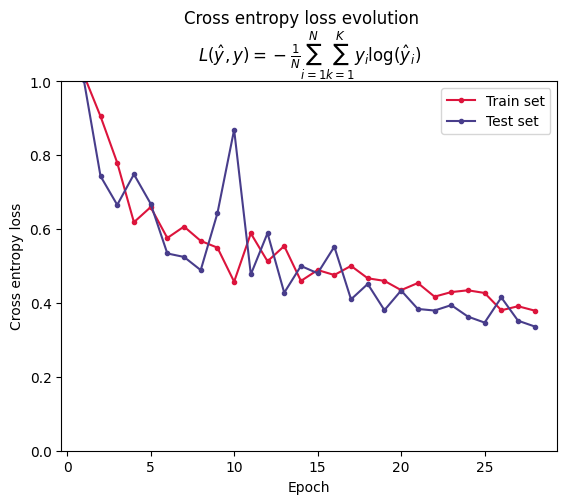

In [87]:
# Display the (total) cross entropy loss evolution curve
Curve.cross_entropy_loss_curve(train_losses, test_losses)

#### Scikit-Learn Logistic Regression Classifier

First, the values of the accuracy, precision, recall and f1-score metrics are presented for the train set:

In [88]:
# Training LogisticRegression Classifier
scikit_logistic_regression = LogisticRegression(max_iter=100, penalty=None)
scikit_logistic_regression.fit(X_train, y_train)

# Using LogisticRegression Classifier
y_scikit = scikit_logistic_regression.predict(X_train)
print(classification_report(y_train, y_scikit))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       1.00      1.00      1.00        16
           2       1.00      1.00      1.00        18

    accuracy                           1.00        50
   macro avg       1.00      1.00      1.00        50
weighted avg       1.00      1.00      1.00        50



Now, the values of the same metrics are presented for the test set. We anticipate lower values for the respective metrics than those calculated for the train set:

In [89]:
# Using LogisticRegression Classifier
y_scikit = scikit_logistic_regression.predict(X_test)
print(classification_report(y_test, y_scikit))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        17
           1       1.00      0.88      0.93        16
           2       0.89      1.00      0.94        17

    accuracy                           0.96        50
   macro avg       0.96      0.96      0.96        50
weighted avg       0.96      0.96      0.96        50



### Observations

TEXT

## Gaussian Naive Bayes Classifier

### Custom Gaussian Naive Bayes Classifier

Consider a general case where we are in $R^d$. We assume that the population from which our data is sampled follows a normal distribution $N(μ, Σ)$. To apply Naive Bayes in $R^d$, we choose to approximate this distribution with a second distribution $N(m, C)$, where $C$ is a diagonal covariance matrix. The latter implies that we consider independence among the variables, leading to zero covariances (and thus a diagonal covariance matrix $C$ where only $COV(X_i, X_i) = VAR(X_i) \geq 0$, for $i=1,...,d)$.

Let $θ = (μ, Σ)$ and $φ = (m, C)$.

Now, we can approach the distribution $N(μ, Σ)$ in two ways:
1. Choose $φ$ s.t. $KL(θ : φ)$ is minimized
2. Choose $φ$ s.t. $KL(φ : θ)$ is minimized, where KL is the Kullback-Liebler divergence

These approaches lead to the following formulas, respectively:
1. $m = μ$, $C = diag(Σ)$
2. $m = μ$, $C = diag(Λ)^{-1}$, where $Λ$ is the precision matrix (i.e. $Λ = Σ^{-1}$)

In the following implementation we use the first formula.

In [90]:
class GaussianNaiveBayes:
    def __init__(self):
        self.classes = None
        self.priors = None
        self.means = None
        self.covariances = None
    
    def fit(self, X_train, y_train):
        self.classes = np.unique(y_train)
        self.priors = {}
        self.means = {}
        self.covariances = {}
        
        for c in self.classes:
            # Separate examples per class 
            class_data = X_train[y_train == c]
            
            # Calculate the prior probability for each class
            self.priors[c] = class_data.shape[0] / X_train.shape[0]

            # Calculate the mean vector for each class: m = [mean(f1), mean(f2),...]
            self.means[c] = np.mean(class_data, axis=0)
            
            # Calculate the covariance vector for each class: C = diag(var(f1), var(f2),...). Note that only the diagonal needs to be stored
            self.covariances[c] = np.var(class_data, axis=0)

    def predict(self, X_test):
        predictions = list()

        for example in X_test:
            class_prob = []
            for c in self.classes:
                # P(c|example) ~ P(c) * P(example|c) = P(c) * P(example|m_c, C_c)
                class_prob.append(self.priors[c] * multivariate_normal.pdf(example, mean = self.means[c], cov=self.covariances[c]))
            predictions.append(self.classes[np.argmax(class_prob)])
        
        return np.array(predictions)

### Training & Testing

#### Custom Gaussian Naive Bayes Classifier

First, the values of the accuracy, precision, recall and f1-score metrics are presented for the train set:

In [91]:
# Training Gaussian Naive Bayes Classifier
gaussian_nb = GaussianNaiveBayes()
gaussian_nb.fit(X_train, y_train)

# Using Gaussian Naive Bayes Classifier (train set)
y_custom = gaussian_nb.predict(X_train)
print(classification_report(y_train, y_custom))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       0.94      1.00      0.97        16
           2       1.00      0.94      0.97        18

    accuracy                           0.98        50
   macro avg       0.98      0.98      0.98        50
weighted avg       0.98      0.98      0.98        50



Now, the values of the same metrics are presented for the test set. We anticipate lower values for the respective metrics than those calculated for the train set:

In [92]:
# Using Gaussian Naive Bayes Classifier (test set)
y_custom = gaussian_nb.predict(X_test)
print(classification_report(y_test, y_custom))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        17
           1       0.82      0.88      0.85        16
           2       0.88      0.82      0.85        17

    accuracy                           0.90        50
   macro avg       0.90      0.90      0.90        50
weighted avg       0.90      0.90      0.90        50



The parameters (priors, means and covariance matrix) are displayed below:

In [93]:
# Print the estimated priors (per class), means (per class and feature) and covariances(per class and feature)
custom_priors = np.asarray(list(gaussian_nb.priors.values()))
custom_means = np.asarray(list(gaussian_nb.means.values()))
custom_num_classes = len(gaussian_nb.classes)
custom_covariances = np.array([np.diag(list(gaussian_nb.covariances.values())[i]) for i in range(custom_num_classes)])

Report.gaussian_naive_bayes_parameters("Custom Gaussian Naive Bayes Classifier", custom_priors, custom_means, custom_covariances, custom_num_classes, X_train.shape[1])

Custom Gaussian Naive Bayes Classifier - Priors


,Class_0,Class_1,Class_2
0,0.32,0.32,0.36


Custom Gaussian Naive Bayes Classifier  - Means


,Feature_0,Feature_1,Feature_2,Feature_3
Class_0,4.963,3.400,1.469,0.219
Class_1,5.956,2.775,4.362,1.381
Class_2,6.656,3.139,5.567,2.078


Custom Gaussian Naive Bayes Classifier  - Covariance Matrix per class


,Feature_0,Feature_1,Feature_2,Feature_3
Feature_0,0.124,0.000,0.000,0.000
Feature_1,0.000,0.112,0.000,0.000
Feature_2,0.000,0.000,0.035,0.000
Feature_3,0.000,0.000,0.000,0.008


,Feature_0,Feature_1,Feature_2,Feature_3
Feature_0,0.289,0.000,0.000,0.000
Feature_1,0.000,0.118,0.000,0.000
Feature_2,0.000,0.000,0.159,0.000
Feature_3,0.000,0.000,0.000,0.028


,Feature_0,Feature_1,Feature_2,Feature_3
Feature_0,0.332,0.000,0.000,0.000
Feature_1,0.000,0.077,0.000,0.000
Feature_2,0.000,0.000,0.268,0.000
Feature_3,0.000,0.000,0.000,0.075


#### Scikit-Learn Gaussian Naive Bayes Classifier

First, the values of the accuracy, precision, recall and f1-score metrics are presented for the train set:

In [94]:
# Training GaussianNB Classifier
scikit_gaussian_nb = GaussianNB()
scikit_gaussian_nb.fit(X_train, y_train)

# Using GaussianNB Classifier (train set)
y_scikit = scikit_gaussian_nb.predict(X_train)
print(classification_report(y_train, y_scikit))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       0.94      1.00      0.97        16
           2       1.00      0.94      0.97        18

    accuracy                           0.98        50
   macro avg       0.98      0.98      0.98        50
weighted avg       0.98      0.98      0.98        50



Now, the values of the same metrics are presented for the test set. We anticipate lower values for the respective metrics than those calculated for the train set:

In [95]:
# Using GaussianNB Classifier (test set)
y_scikit = scikit_gaussian_nb.predict(X_test)
print(classification_report(y_test, y_scikit))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        17
           1       0.82      0.88      0.85        16
           2       0.88      0.82      0.85        17

    accuracy                           0.90        50
   macro avg       0.90      0.90      0.90        50
weighted avg       0.90      0.90      0.90        50



The parameters (priors, means and covariance matrix) are displayed below:

In [96]:
# Print the estimated priors (per class), means (per class and feature) and covariances(per class and feature)
scikit_priors = scikit_gaussian_nb.class_prior_
scikit_means = scikit_gaussian_nb.theta_
scikit_num_classes = len(scikit_gaussian_nb.classes_)
scikit_covariances = np.array([np.diag(scikit_gaussian_nb.var_[i]) for i in range(scikit_num_classes)])
scikit_num_features = scikit_gaussian_nb.n_features_in_

Report.gaussian_naive_bayes_parameters("Scikit-Learn Gaussian Naive Bayes Classifier", scikit_priors, scikit_means, scikit_covariances, scikit_num_classes, scikit_num_features)


Scikit-Learn Gaussian Naive Bayes Classifier - Priors


,Class_0,Class_1,Class_2
0,0.32,0.32,0.36


Scikit-Learn Gaussian Naive Bayes Classifier  - Means


,Feature_0,Feature_1,Feature_2,Feature_3
Class_0,4.963,3.400,1.469,0.219
Class_1,5.956,2.775,4.362,1.381
Class_2,6.656,3.139,5.567,2.078


Scikit-Learn Gaussian Naive Bayes Classifier  - Covariance Matrix per class


,Feature_0,Feature_1,Feature_2,Feature_3
Feature_0,0.124,0.000,0.000,0.000
Feature_1,0.000,0.113,0.000,0.000
Feature_2,0.000,0.000,0.035,0.000
Feature_3,0.000,0.000,0.000,0.008


,Feature_0,Feature_1,Feature_2,Feature_3
Feature_0,0.289,0.000,0.000,0.000
Feature_1,0.000,0.118,0.000,0.000
Feature_2,0.000,0.000,0.159,0.000
Feature_3,0.000,0.000,0.000,0.028


,Feature_0,Feature_1,Feature_2,Feature_3
Feature_0,0.332,0.000,0.000,0.000
Feature_1,0.000,0.077,0.000,0.000
Feature_2,0.000,0.000,0.268,0.000
Feature_3,0.000,0.000,0.000,0.075


### Observations

TEXT HERE